# Analyze an advertisement image

In this lab, we will use BDA to extract and analyze a sample advertisement image, utilizing both standard output settings and a customized blueprint for deeper insights. We will walk through the process and explore the generated outputs.

![video moderation](../static/bda-image-travel.png)

## Prerequisits

In [32]:
%pip install "boto3>=1.37.4" --upgrade -qq

Note: you may need to restart the kernel to use updated packages.


In [33]:
import boto3
import json
import uuid
import utils
import sagemaker

bda_client = boto3.client('bedrock-data-automation')
bda_runtime_client = boto3.client('bedrock-data-automation-runtime')
s3_client = boto3.client('s3')

For a self-hosted workshop, we recommend creating a new S3 bucket in the same region where you plan to run the workshop. You can name it `bda-workshop-YOUR_ACCOUNT_ID-YOUR_REGION`.

In [34]:
data_bucket = sagemaker.Session().default_bucket() # Enter your bucket name here
data_prefix = "bda-workshop/image"
output_prefix = "bda-workshop/image/ouput"

print('Workshop S3 bucket:', data_bucket)

Workshop S3 bucket: sagemaker-us-west-2-396608773413


In [35]:
# Get current AWS account Id and region
sts = boto3.client('sts')
account_id = sts.get_caller_identity()['Account']
region = boto3.Session().region_name

print(f'Current AWS account Id: {account_id}, region name: {region}')

Current AWS account Id: 396608773413, region name: us-west-2


## Create a BDA project with both standard and custom output configurations for image
To start a BDA job, you need a BDA project, which organizes both standard and custom output configurations. This project is reusable, allowing you to apply the same configuration to process multiple images that share the same settings.

In the code snippet below, we create a BDA project with standard and custom output configurations for image modality. These configurations can be tailored to extract only the specific information you need. In this lab, we will enable the below standard image outputs:
- Text detection with bounding-box
- Brand and logos with bounding-box
- IAB categories on the scene level
- Image summary

We will also set up a custom output configuration by defining a blueprint to extract and infer customized properties.

For a complete API reference for creating a BDA project, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation/client/create_data_automation_project.html). For creating a BDA blue print, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation/client/create_blueprint.html).

In [36]:
def create_project(blue_print_arn):
    response = bda_client.create_data_automation_project(
        projectName=f'bda-workshop-image-project-{str(uuid.uuid4())[0:4]}',
        projectDescription='BDA workshop image sample project',
        projectStage='DEVELOPMENT',
        standardOutputConfiguration={
            'image': {
                'extraction': {
                    'category': {
                        'state': 'ENABLED',
                        'types': [
                            'TEXT_DETECTION','LOGOS'
                        ]
                    },
                    'boundingBox': {
                        'state': 'ENABLED'
                    }
                },
                'generativeField': {
                    'state': 'ENABLED',
                    'types': [
                        'IMAGE_SUMMARY','IAB'
                    ]
                }
            },
        },
        customOutputConfiguration={
            'blueprints': [
                {
                    'blueprintArn': blue_print_arn,
                    'blueprintStage': 'DEVELOPMENT'
                },
            ]
        },
    )
    return response

We will create a blueprint and pass it to the BDA project with the following customized output definitions:
- Number of products in the image
- Scene location
- Product type
- Image background color

For more information on creating a BDA image blueprint, refer to this [document](https://docs.aws.amazon.com/bedrock/latest/userguide/bda-idp-images.html).

In [37]:
blueprint = {
    "class": "Ad scene analysis",
    "description": "This blueprint is designed to extract key information from an image depicting an Ad scene.",
    "definitions": {
        "ProductDetails": {
            "properties": {
                "product_type": {
                  "type": "string",
                  "inferenceType": "inferred",
                  "instruction": "What is the primary product or service being advertised, e.g., Clothing, Electronics, Food & Beverage, etc.?"
                },
                "product_count": {
                    "type": "number",
                    "inferenceType": "inferred",
                    "instruction": "Count the number of product visible in the image."
                },
                "scene_location": {
                  "type": "string",
                  "inferenceType": "inferred",
                  "instruction": "Describe the setting or location of the scene, such as the type of field or surrounding buildings."
                }
            }
        }
    },
    "properties": {
        "product_details": {
            "instruction": "Detailed information about the advertised product, including its category, name, and placement within the image.",
            "$ref": "#/definitions/ProductDetails"
        },
        "image_background": {
            "type": "string",
            "inferenceType": "inferred",
            "instruction": "What is the background of the ad image? For example, \\u0027Solid color\\u0027, \\u0027Natural landscape\\u0027, \\u0027Indoor\\u0027, \\u0027Urban\\u0027, \\u0027Abstract\\u0027"
        }
    }
}

bp_response = bda_client.create_blueprint(
    blueprintName='bda-image-custom-bpx',
    type='IMAGE',
    blueprintStage='DEVELOPMENT',
    schema=json.dumps(blueprint),
)
blueprint_arn = bp_response.get("blueprint",{}).get("blueprintArn")

In [38]:
response = create_project(blueprint_arn)

The create_data_automation_project API will return the project ARN, which we will use it to invoke the BDA job.

In [39]:
image_project_arn = response.get("projectArn")
print("BDA image project ARN:", image_project_arn)

BDA image project ARN: arn:aws:bedrock:us-west-2:396608773413:data-automation-project/c2589191b6f2


## Start an asynchronous BDA task to extract and analyze an image
In this section, we will use a sample advertising product image to extract and analyze data using BDA, applying the configuration defined in the BDA project. We will then review the output to better understand how BDA performs image extraction and analysis.

### Prepare the sample image
Download the sample image

In [40]:
# Download sample image
sample_image = 'travel.png'
source_url = f'https://d1xvhy22zmw77y.cloudfront.net/tmp/{sample_image}'

!curl {source_url} --output {sample_image}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  399k  100  399k    0     0  2873k      0 --:--:-- --:--:-- --:--:-- 2877k


Let's display the image.

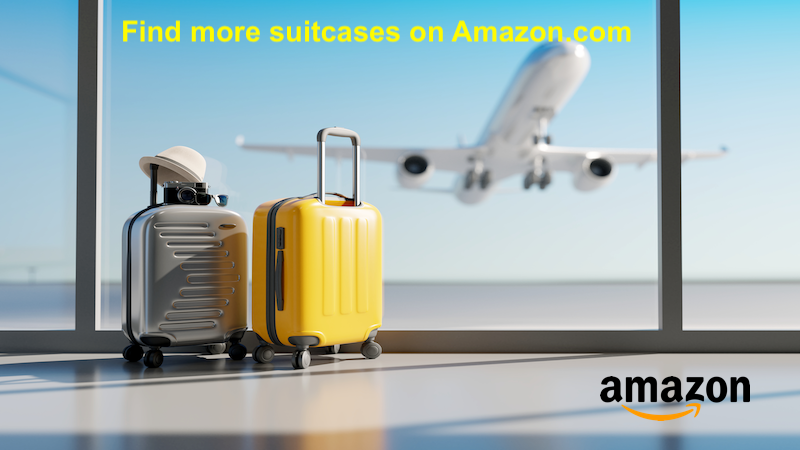

In [41]:
from IPython.display import Image
Image(sample_image, width=800)

To analyze the image using BDA, we need to upload it to an S3 bucket that BDA can access. 

In [42]:
s3_key = f'{data_prefix}/{sample_image.split("/")[-1]}'
s3_client.upload_file(sample_image, data_bucket, s3_key)

### Start BDA task
We will now invoke the BDA API to process the uploaded image. You need to provide the BDA project ARN that we created at the beginning of the lab and specify an S3 location where BDA will store the output results.

For a complete API reference for invoke a BDA async task, refer to this [document](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-data-automation-runtime/client/invoke_data_automation_async.html).

In [43]:
response = bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={
        's3Uri': f's3://{data_bucket}/{s3_key}'
    },
    outputConfiguration={
        's3Uri': f's3://{data_bucket}/{output_prefix}'
    },
    dataAutomationConfiguration={
        'dataAutomationProjectArn': image_project_arn,
        'stage': 'DEVELOPMENT'
    },
    notificationConfiguration={
        'eventBridgeConfiguration': {
            'eventBridgeEnabled': False
        }
    },
    dataAutomationProfileArn=f'arn:aws:bedrock:{region}:{account_id}:data-automation-profile/us.data-automation-v1'
)

The `invoke_data_automation_async` API is asynchronous. It returns an invocation task identifier, `invocationArn`. We can then use another API `get_data_automation_status` to monitor the task's status until it completes.

> In production workloads, an event-driven pattern is recommended. Allow BDA to trigger the next step once the task is complete. This can be achieved by configuring the notificationConfiguration in the invoke task, which will send a notification to a subscribed AWS service, such as a Lambda function. Alternatively, you can set up an S3 trigger on the bucket where BDA will drop the results.

In [44]:
invocation_arn = response.get("invocationArn")
print("BDA task started:", invocation_arn)

BDA task started: arn:aws:bedrock:us-west-2:396608773413:data-automation-invocation/c8bfa474-8812-4451-a845-d6e7af27b6ed


In this lab, we will use the loop below to monitor the task by calling the `get_data_automation_status` API every 5 seconds until the task is complete.

In [45]:
import time
from IPython.display import clear_output
from datetime import datetime

status, status_response = None, None
while status not in ["Success","ServiceError","ClientError"]:
    status_response = bda_runtime_client.get_data_automation_status(
        invocationArn=invocation_arn
    )
    status = status_response.get("status")
    clear_output(wait=True)
    print(f"{datetime.now().strftime('%H:%M:%S')} : BDA image task: {status}")
    time.sleep(5)

output_config = status_response.get("outputConfiguration",{}).get("s3Uri")
print("Ouput configureation file:", output_config)

15:29:05 : BDA image task: Success
Ouput configureation file: s3://sagemaker-us-west-2-396608773413/bda-workshop/image/ouput/c8bfa474-8812-4451-a845-d6e7af27b6ed/job_metadata.json


## Access the BDA analysis result
The `get_data_automation_status` API returns an S3 URI containing the result configuration, which provides the S3 location where BDA outputs the extraction results. We will then parse this file to retrieve the result path.

In [46]:
config_data = utils.read_json_on_s3(output_config,s3_client)
print(json.dumps(config_data, indent=4))

{
    "job_id": "c8bfa474-8812-4451-a845-d6e7af27b6ed",
    "job_status": "PROCESSED",
    "semantic_modality": "IMAGE",
    "output_metadata": [
        {
            "asset_id": 0,
            "asset_input_path": {
                "s3_bucket": "sagemaker-us-west-2-396608773413",
                "s3_key": "bda-workshop/image/travel.png"
            },
            "segment_metadata": [
                {
                    "standard_output_path": "s3://sagemaker-us-west-2-396608773413/bda-workshop/image/ouput/c8bfa474-8812-4451-a845-d6e7af27b6ed/0/standard_output/0/result.json",
                    "custom_output_path": "s3://sagemaker-us-west-2-396608773413/bda-workshop/image/ouput/c8bfa474-8812-4451-a845-d6e7af27b6ed/0/custom_output/0/result.json",
                    "custom_output_status": "MATCH"
                }
            ]
        }
    ]
}


As shown above, the BDA output configuration file contains metadata about the BDA result, including the job ID, status, modality, and the S3 location of the standard and custom output locations: `standard_output_path`, `custom_output_path`. We will now download these result files to verify the output.

The standard output result file contains extraction and inference results based on the configuration defined in the BDA image project's standard output configuration section. Under the image field, you will find details such as the summary, IAB categories, and more.

In [47]:
from IPython.display import JSON

result_uri = config_data["output_metadata"][0]["segment_metadata"][0]["standard_output_path"]
result_data = utils.read_json_on_s3(result_uri,s3_client)

JSON(result_data)

<IPython.core.display.JSON object>

## Review the result - custom output
The custom output result file contains extracted and inferred results based on the blueprint definition.
- The `matched_blueprint` field indicates which blueprint BDA used to process the image.
- Under the `inference_result` field, you will find the customized properties and results based on the blueprint definition.

In [48]:
custom_output_uri = config_data["output_metadata"][0]["segment_metadata"][0]["custom_output_path"]
custom_output_data = utils.read_json_on_s3(custom_output_uri,s3_client)

JSON(custom_output_data)

<IPython.core.display.JSON object>

## Review the result - standard output
The standard output contains information such as the image summary, IAB categories, and extracted text with bounding boxes.

### Image summary

In [49]:
print(result_data["image"]["summary"])

This image shows a scene at an airport terminal. In the foreground, there are two suitcases - one gray and one yellow - placed on a counter. In the background, a commercial airplane can be seen taking off through a large window. The image also displays a text overlay that advertises "Find more suitcases on Amazon.com", along with the Amazon logo.


### IAB categories

In [50]:
for iab in result_data["image"]["iab_categories"]:
    print(iab["category"])

Travel
Travel Accessories


### Text in image with bounding boxes
Now, let's examine the text extracted from the image. We have enabled bounding boxes in the BDA project’s standard output configuration. Below is the code to plot the bounding boxes along with the extracted text from the image.

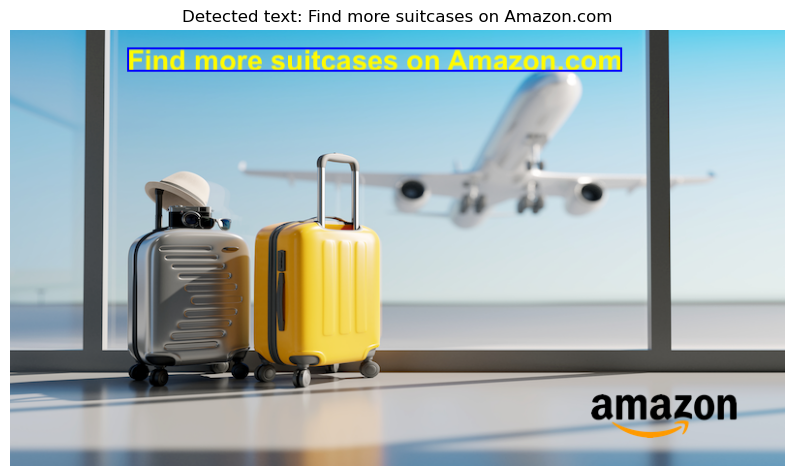

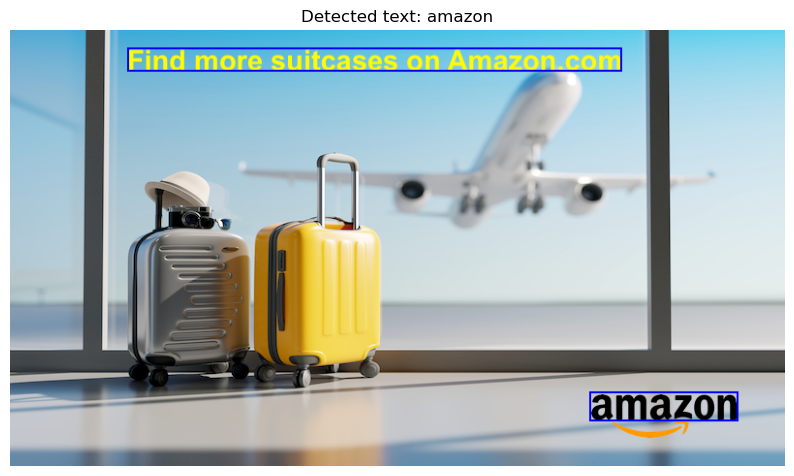

In [51]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

width = result_data["metadata"]["image_width_pixels"]
height = result_data["metadata"]["image_height_pixels"]

image = Image.open(sample_image)
draw = ImageDraw.Draw(image)

for txt in result_data["image"]["text_lines"]:
    for l in txt["locations"]:
        bbox = l["bounding_box"]
        box = (
                width*bbox["left"], 
                height*bbox["top"], 
                width * (bbox["width"]+bbox["left"]), 
                height * (bbox["height"] + bbox["top"])
            )
        draw.rectangle(box, outline="blue", width=2)
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title(f'Detected text: {txt["text"]}')
        plt.axis("off")
        plt.show()

### Brand and logos in image with bounding boxes
Brand and logo information, including bounding boxes and confidence scores, can be found in the standard output under the image.logos field. The code snippet below uses the Pillow library to plot the detected logos from the image.

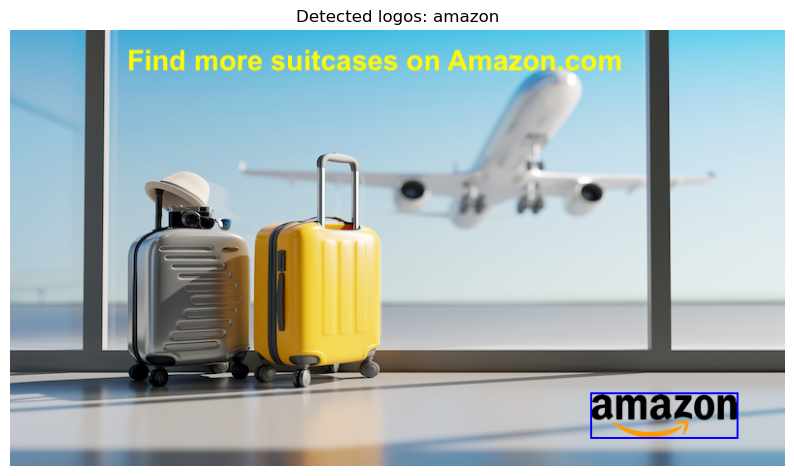

In [52]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

width = result_data["metadata"]["image_width_pixels"]
height = result_data["metadata"]["image_height_pixels"]

image = Image.open(sample_image)
draw = ImageDraw.Draw(image)

if "logos" in result_data["image"]:
    for logo in result_data["image"]["logos"]:
        for l in logo["locations"]:
            bbox = l["bounding_box"]
            box = (
                    width*bbox["left"], 
                    height*bbox["top"], 
                    width * (bbox["width"]+bbox["left"]), 
                    height * (bbox["height"] + bbox["top"])
                )
            draw.rectangle(box, outline="blue", width=2)
            plt.figure(figsize=(10, 6))
            plt.imshow(image)
            plt.title(f'Detected logos: {logo["name"]}')
            plt.axis("off")
            plt.show()
else:
    print("No logo detected")

## Clean up
Delete the BDA project, blueprint, image, and result from S3.

In [53]:
# delete BDA project
response = bda_client.delete_data_automation_project(
    projectArn=image_project_arn
)
response

{'ResponseMetadata': {'RequestId': 'abd59690-0d71-459d-b294-ceb95bb82d8d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 25 Mar 2025 15:29:11 GMT',
   'content-type': 'application/json',
   'content-length': '115',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'abd59690-0d71-459d-b294-ceb95bb82d8d'},
  'RetryAttempts': 0},
 'projectArn': 'arn:aws:bedrock:us-west-2:396608773413:data-automation-project/c2589191b6f2',
 'status': 'IN_PROGRESS'}

In [54]:
# delete blueprint
response = bda_client.delete_blueprint(
    blueprintArn=blueprint_arn,
)
response

{'ResponseMetadata': {'RequestId': '152b0166-f93e-4c7f-9245-a34eb738476d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 25 Mar 2025 15:29:12 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '152b0166-f93e-4c7f-9245-a34eb738476d'},
  'RetryAttempts': 0}}

In [55]:
# delete uploaded image from S3
s3_client.delete_object(Bucket=data_bucket, Key=s3_key)

{'ResponseMetadata': {'RequestId': 'GHV8TCWK11HV7RXX',
  'HostId': 'b3KHA9uDeZBGVGlz0tV+bPYR03llgVyuhV3tx65AyEh4OexokPfPlrUEUPDc0mx7W02HwsXPE5g=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'b3KHA9uDeZBGVGlz0tV+bPYR03llgVyuhV3tx65AyEh4OexokPfPlrUEUPDc0mx7W02HwsXPE5g=',
   'x-amz-request-id': 'GHV8TCWK11HV7RXX',
   'date': 'Tue, 25 Mar 2025 15:29:13 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [56]:
# delete results from S3
utils.delete_s3_folder(data_bucket, output_config.replace("job_metadata.json","") ,s3_client)

No objects found in folder: s3://sagemaker-us-west-2-396608773413/bda-workshop/image/ouput/c8bfa474-8812-4451-a845-d6e7af27b6ed/
